<span style="float:left;">Licence CC BY-SA</span><span style="float:right;">Fabrice Zaoui - Cedric Goeury&nbsp;</span><br/>
___

This tutorial is intended for people who want an example showing how to compute the flow rate along a polygonal chain.

In [1]:
from data_manip.computation.polyline_integrals import flux_2d

The module 'polyline_integrals' is located in the '$HOMETEL/scripts/python3/data_manip/computation' directory. If an error occurs while attempting to import, check the value of the environment variable PYTHONPATH.


# 1. Flow rate computation using user-defined data

In [2]:
import numpy as np
from utils.geometry import get_norm2
from utils.exceptions import TelemacException

Here we fill an array with coordinates for a polyline.
The aim here is to use the extraction instead when it is ready.
The direction of the polyline has an importance:
- to measure fluxes positive in the x direction, create the polyline from low values of y towards higher values;
- to measure fluxes positive in the y direction, create the polyline from high values of x towards lower values.

Here for example, we create a polyline from lower x values towards higher x values. Any flux going in the y direction will thus be negative in this case.

In [3]:
polyline_coords = np.array([[0., 0.], [0.1, 0.], [0.2, 0.], [0.3, 0.], [0.4, 0.], [0.5, 0.]])

Here we fill arrays with the x and y precomputed fluxes: either HU, HV to compute the flow rate or QBX, QBY to compute a sediment discharge. The aim here is to use the extraction instead when it is ready.


In [4]:
flux_x = np.ones((6, 1))
flux_y = np.zeros((6, 1))

Here we compute the flow rate using the flux_2d function. It integrates (HU, HV) times the normal to the polygonal chain.


In [5]:
flow_rate = flux_2d(polyline_coords, flux_x, flux_y)
print(flow_rate)

[0.]


The result is obviously correct: here we prescribed velocities tangential to the polygonal chain. Now if we orient the velocities in the y direction:

In [6]:
flux_x = np.zeros((6, 1))
flux_y = np.ones((6, 1))
flow_rate = flux_2d(polyline_coords, flux_x, flux_y)
print(flow_rate)

[-0.5]


We get the correct result: since the polyline was constructed from low values of x towards higher values, the flux in the y-direction is negative.

In [7]:
polyline_coords = np.array([[0., 0.], [0.1, 0.1], [0.2, 0.2], [0.3, 0.3], [0.4, 0.4], [0.5, 0.5]])
flux_x = np.ones((6, 1))
flux_y = np.zeros((6, 1))
flow_rate = flux_2d(polyline_coords, flux_x, flux_y)
print(flow_rate)

[0.5]


Now we have measured a flux going in the x-direction, which is thus positive.

# 2. Flow rate computation using the confluence Telemac2D result file

We need some additional imports to open the file, define the polygonal chain and extract the data.

In [8]:
from os import chdir, environ, path
from data_manip.extraction.telemac_file import TelemacFile
import numpy as np

First, define the Telemac2D result file to be used.

In [9]:
file_name = path.join(environ['HOMETEL'], 
                          'examples', 
                          'telemac2d', 
                          'confluence',
                          'f2d_confluence.slf')

res = TelemacFile(file_name)

# Getting array of time values from file 
times = res.times

We can visualise the case through a 2d plot first.

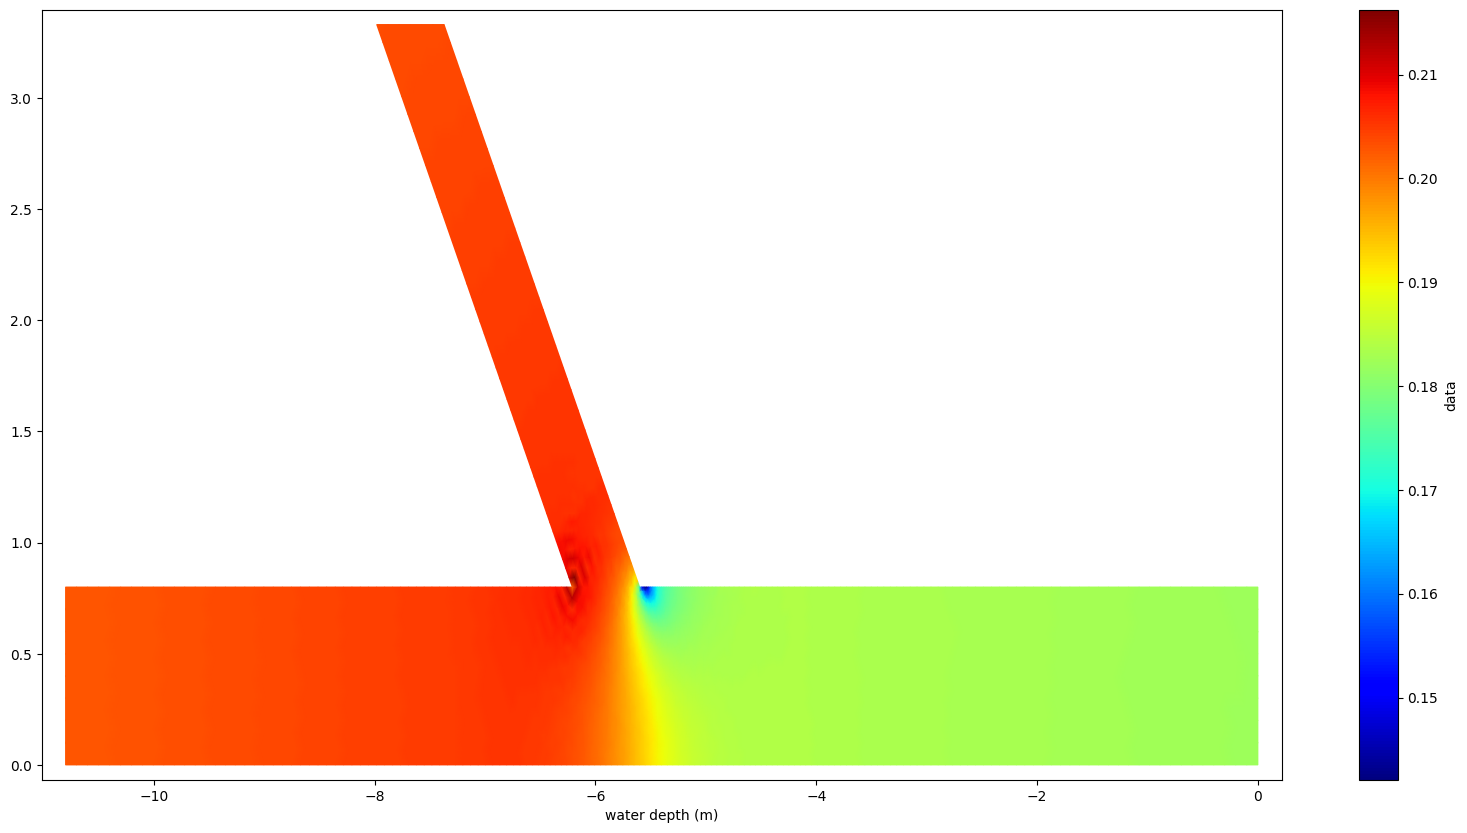

In [10]:
import matplotlib.pyplot as plt
from postel.plot2d import plot2d_scalar_map

# Initialising matplotlib figure
fig, ax = plt.subplots(figsize=(20, 10))

data = res.get_data_value('WATER DEPTH', 1)

# Plotting scalar map
plot2d_scalar_map(fig, ax, res.tri, data, 'water depth (m)')
    
# Showing the plot
plt.show()

Then, define three lines as arrays of np.array elements (required for the interpolation, check the Doxygen documentation of the script data_manip.extraction.telemac_file.py for more details). 

Define also the number of segments to be used for the discretisation of each line.

In [11]:
line1 = [np.array([-10.,0.0]),np.array([-10.,0.8])]
line1_num = [20]

line2 = [np.array([-7.5871568214477882,2.7718446471440905]),np.array([-7.1535131343706952,3.0167019187627968])]
line2_num = [20]

line3 = [np.array([-1.0,0.0]),np.array([-1.0,0.8])]
line3_num = [20]

Get the water depth and velocity values over time for each discretized points of the polyline.

In [12]:
l1_discrete, l1_abs_curv, l1_water_depth = res.get_timeseries_on_polyline('WATER DEPTH',line1,line1_num)
l1_discrete, l1_abs_curv, l1_vel_u = res.get_timeseries_on_polyline('VELOCITY U',line1,line1_num)
l1_discrete, l1_abs_curv, l1_vel_v = res.get_timeseries_on_polyline('VELOCITY V',line1,line1_num)

l2_discrete, l2_abs_curv, l2_water_depth = res.get_timeseries_on_polyline('WATER DEPTH',line2,line2_num)
l2_discrete, l2_abs_curv, l2_vel_u = res.get_timeseries_on_polyline('VELOCITY U',line2,line2_num)
l2_discrete, l2_abs_curv, l2_vel_v = res.get_timeseries_on_polyline('VELOCITY V',line2,line2_num)

l3_discrete, l3_abs_curv, l3_water_depth = res.get_timeseries_on_polyline('WATER DEPTH',line3,line3_num)
l3_discrete, l3_abs_curv, l3_vel_u = res.get_timeseries_on_polyline('VELOCITY U',line3,line3_num)
l3_discrete, l3_abs_curv, l3_vel_v = res.get_timeseries_on_polyline('VELOCITY V',line3,line3_num)

Compute the flux at each point and each time on the polygonal chain.

In [13]:
flux1_x = np.multiply(l1_vel_u, l1_water_depth)
flux1_y = np.multiply(l1_vel_v, l1_water_depth)

flux2_x = np.multiply(l2_vel_u, l2_water_depth)
flux2_y = np.multiply(l2_vel_v, l2_water_depth)

flux3_x = np.multiply(l3_vel_u, l3_water_depth)
flux3_y = np.multiply(l3_vel_v, l3_water_depth)

Now compute the flow rate through each line:

In [14]:
flow_rate_1 = flux_2d(l1_discrete, flux1_x, flux1_y)
flow_rate_2 = flux_2d(l2_discrete, flux2_x, flux2_y)
flow_rate_3 = flux_2d(l3_discrete, flux3_x, flux3_y)

We can check the flow rate values at the final time, which should be 0.07 m3/s, 0.035 m3/s and 0.105 m3/s.

In [15]:
print("Main inlet:", flow_rate_1[1], "(m3/s)")
print("Secondary inlet:", flow_rate_2[1], "(m3/s)")
print("Outlet:", flow_rate_3[1], "(m3/s)")

Main inlet: 0.0699988095473791 (m3/s)
Secondary inlet: 0.03469574798993031 (m3/s)
Outlet: 0.10492863254979264 (m3/s)
